# Topic 1: Finding the ground state of a molecule via VQE

Based on example from https://github.com/qiskit-community/qiskit-nature-pyscf

## Table of contents

1.
2.

## Introduction

This exercise provides a very small, illustrative prototype of what one does in the area of material science, chemistry and pharmacuticals for the purpose of property computations, predictions, and computational material discovery.

### Use case

What we're doing and why

### Theory

Explain classical and quantum solution

In this notebook, we investigate the ground-state electronic structure of dimers (molecules made up of two atoms) using both classical and quantum computational methods. Traditional quantum chemistry approaches such as Full Configuration Interaction (FCI) provide accurate results for small molecules, but quickly become too computationally expensive as the number of orbitals increases for larger molecules. To explore the potential of quantum computing in this domain, we employ the Variational Quantum Eigensolver (VQE) with a Unitary Coupled Cluster (UCCSD) ansatz, using Qiskit. By comparing the computed ground-state energies from HF, FCI, and VQE across different bond lengths, we assess the accuracy and feasibility of hybrid quantum-classical simulations for molecular electronic structure problems.

## VQE tutorial

### Imports and setup

In [2]:
from pyscf import gto, scf, mcscf, fci # pyscf = (classical) python-based simulations of chemistry framework

# gto.M defines molecular geometry & basis set
# scf.RHF restricted Hartree-Fock
# mcscf.CASCI complete active space configuration interaction

import numpy as np
import matplotlib.pyplot as plt
from mermaid import Mermaid # for flowchart

from qiskit.primitives import Estimator # expectation values
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit.visualization import circuit_drawer # to show vqe circuit

from qiskit_nature_pyscf import QiskitSolver

ModuleNotFoundError: No module named 'mermaid'

Flowchart summarising the main steps of this notebook:

```mermaid
%%{init: {
        'theme': 'base',
        'themeVariables': {
        'primaryColor': '#BB2528',
        'primaryTextColor': '#fff',
        'primaryBorderColor': '#7C0000',
        'lineColor': '#F8B229',
        'secondaryColor': '#006100',
        'tertiaryColor': '#fff'
        }
    }}%%

    graph TD
    A[Define Molecule]
    A --> B[Select active orbitals & electrons]
    B --> C[Choose Qubit Mapping: Jordan-Wigner/Parity]
    C --> D[Select Ansatz: UCCSD, PUCCD, etc. This defines circuit structure.]
    D --> E[Initialize Parameters - all zero]
    E --> F[Initial state = Hartree-Fock state]
    F --> G[Run Quantum Circuit & Measure]
    G --> H[Compute Energy i.e. Expectation Value of Hamiltonian]
    H --> I{Convergence?}
    I -- No --> J[Update Parameters via Classical Optimizer] --> G
    I -- Yes --> K[Return Optimized Energy & Parameters];
```

```mermaid
graph TD
subgraph Problem
direction LR;
    A((Define Molecule))
    A --> B(Select active orbitals & electrons)
end
    
subgraph Mapping
direction LR;
    C(Choose Qubit Mapping: Jordan-Wigner/Parity)
    C --> D(Select Ansatz: UCCSD, PUCCD, etc. This defines circuit structure.)
end
    Problem --> Mapping
    
subgraph Circuit
direction LR;
    E(Initialize Parameters - all zero)
    E --> F(Initial state = Hartree-Fock state)
    F --> G(Run Quantum Circuit & Measure)
end
    Mapping --> Circuit
    
    Circuit --> H(Compute Energy i.e. Expectation Value of Hamiltonian)
    H --> I{Convergence?}
    I -- No --> J(Update Parameters via Classical Optimizer) --> Circuit
    I -- Yes --> K(Return Optimized Energy & Parameters);
```

In [ ]:
Mermaid("""%%{
    init: {
        'theme': 'base',
        'themeVariables': {
        'primaryColor': '#BB2528',
        'primaryTextColor': '#fff',
        'primaryBorderColor': '#7C0000',
        'lineColor': '#F8B229',
        'secondaryColor': '#006100',
        'tertiaryColor': '#fff'
        }
    }
    }%%
    graph TD
subgraph Problem
direction LR;
    A((Define Molecule))
    A --> B(Select active orbitals & electrons)
end
    
subgraph Mapping
direction LR;
    C(Choose Qubit Mapping: Jordan-Wigner/Parity)
    C --> D(Select Ansatz: UCCSD, PUCCD, etc. This defines circuit structure.)
end
    Problem --> Mapping
    
subgraph Circuit
direction LR;
    E(Initialize Parameters - all zero)
    E --> F(Initial state = Hartree-Fock state)
    F --> G(Run Quantum Circuit & Measure)
end
    Mapping --> Circuit
    
    Circuit --> H(Compute Energy i.e. Expectation Value of Hamiltonian)
    H --> I{Convergence?}
    I -- No --> J(Update Parameters via Classical Optimizer) --> Circuit
    I -- Yes --> K(Return Optimized Energy & Parameters);
""")

NameError: name 'Mermaid' is not defined

In [3]:
def run_vqe(mapper, norb, nalpha, nbeta, h_f):
    """
    Prepare a quantum computing-based method to solve the electronic structure problem.

    Parameters
    ----------
    norb : int
        Number of active orbitals
    nalpha : int
        Number of alpha (spin up) electrons
    nbeta : int
        Number of beta (spin down) electrons
    h_f : method
        Hartree-Fock method used to calculate the initial guess for the electronic structure.

    Returns
    -------
    total_energy : float
        The total energy of the system calculated by the CASCI method. This value 
        includes the electron correlation effects within a predefined active space 
        of orbitals.
    
    ansatz : UCCSD
        The quantum circuit ansatz (final version after parameter optimization) 
        used in the VQE algorithm.

    vqe : VQE
        The VQE optimizer object, which contains the optimized parameters used 
        in the ansatz.

    Notes
    -----
    The total energy (`cas.e_tot`) is computed using the Complete Active Space 
    Configuration Interaction (CASCI) method. CASCI selects a set of active 
    orbitals and performs a configuration interaction calculation to account for 
    electron correlation within the active space.

    The optimized ansatz is obtained after running the VQE algorithm, which minimizes 
    the energy of the quantum state described by the UCCSD ansatz.
    """
    nelec = nalpha + nbeta
    
    ansatz = UCCSD( # Unitary Coupled Cluster with Single and Double excitations (trial wavefunction)
        norb,
        (nalpha, nbeta),
        mapper,
        initial_state=HartreeFock(
            norb,
            (nalpha, nbeta),
            mapper,
        ),
    )
    # list of predefined  ansatzes: https://qiskit-community.github.io/qiskit-nature/apidocs/qiskit_nature.second_q.circuit.library.html
    
    vqe = VQE(Estimator(), ansatz, SLSQP()) 
    # to minimise the ground-state energy using classical Sequential Least Squares Programming optimisation
    # list of optimizers: https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html
    
    vqe.initial_point = np.zeros(ansatz.num_parameters)
    
    algorithm = GroundStateEigensolver(mapper, vqe)

    cas = mcscf.CASCI(h_f, norb, nelec) # selects active orbitals and electrons
    cas.fcisolver = QiskitSolver(algorithm)
    #replaces the default FCI solver in PySCF with the VQE-based quantum solver
    
    cas.run()
    return cas.e_tot, ansatz

basis_dict = {'H': 1, 'He': 1, 'Li': 5, 'Be': 5, 'B': 5, 'C': 5, 'N': 5, 'O': 5, 'F': 5}
frozen_dict = {'H': 0, 'He': 0, 'Li': 0, 'Be': 0, 'B': 1, 'C': 1, 'N': 1, 'O': 1, 'F': 1}

In [4]:
# Dictionary of dimers with atom labels and bond lengths in Angstroms
dimers = {
    "H2":   ("H", "H", 0.74),
    "LIH":  ("Li", "H", 1.6),
    "CO":   ("C", "O", 1.13),
    "N2":   ("N", "N", 1.1),
    "O2":   ("O", "O", 1.21),
}

def create_dimer(name, basis='sto-3g'):
    """Create a molecular dimer from name and return the PySCF molecule object."""
    try:
        A, B, bond_length = dimers[name.upper()] # <- Normalize to uppercase
    except KeyError:
        raise ValueError(f"Molecule '{name}' not found in dimers dictionary.")
    
    mol = gto.Mole()
    mol.atom = [
        [A, (0.0, 0.0, 0.0)],
        [B, (0.0, 0.0, bond_length)]
    ]
    mol.basis = basis
    mol.build()
    return mol

In [5]:
def create_stretchable_dimer(bond_length):
    """ Function to create a LiH molecule with variable bond length"""
    return gto.M(
        atom=f"Li 0 0 0; H 0 0 {bond_length}", basis="sto-3g"
    )

### Example: LiH

We now use the algorithm defined above to calculate the ground state energy of LiH.

In [6]:
# Defining the LiH molecule created with STO-3G basis set
mol = create_dimer("LiH")
print(mol._atom)
# NB positions will be in Bohr radii (PySCF internally converts to Bohr radii upon building the molecule)
# conversion: 1 Angstrom = 1.88973 Bohr radii

[('Li', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 3.0235617993040993])]


Select the active orbitals to simulate:
- Electronic structures of lithium and hydrogen are as follows
    - Li: $1s^12s^12p^0$
    - H:  $1s^1$

* The inner 1s orbital of Li is frozen, i.e. these two electrons are paired as $\ket{\uparrow\downarrow}$. We do not include these in the simulation, to reduce the number of qubits required.
* For the five spatial orbitals that we are including in our simulation ($1\times$ Li 2s, $3\times$  Li 2p and $1\times$ H 1s) we need two qubits each, one to represent occupied/unoccupied and one to encode spin up/down
* In total: 10 qubits

In [7]:
# Define constants
norb = 5 # Number of active orbitals
nalpha, nbeta = 1, 1 # One alpha (spin up) and one beta (spin down) electron
#nelec = nalpha + nbeta # Two valence electrons total

We import two mappers, giving us two different ways to convert the electronic structure of a molecule from a fermionic problem to a qubit problem.
1. Jordan-Wigner Mapper: Simple, intuitive
    - 1 spin orbital $\rightarrow$ 1 qubit
    - unoccupied $\rightarrow\ket{0}$; occupied $\rightarrow\ket{1}$
    - spin down $\rightarrow\ket{0}$; spin up $\rightarrow\ket{1}$

2. Parity Mapper: Can reduce number of qubits required in certain cases
    - the Parity Mapper transforms the problem into global parity information instead of directly encoding individual occupation numbers
    - each qubit stores the total parity of all previous orbitals.



In [8]:
# choose mapper
mapper = JordanWignerMapper()
#mapper = ParityMapper(num_particles=(nalpha, nbeta))

In [9]:
# runs Restricted Hartree-Fock to get molecular orbitals and reference (HF) energy (from mean-field approx)
h_f = scf.RHF(mol).run()
energy_hf = h_f.e_tot

converged SCF energy = -7.86186476980865


In [10]:
energy_vqe, ansatz = run_vqe(mapper,norb, nalpha, nbeta, h_f)

/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_33912/2552438785.py:55: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe = VQE(Estimator(), ansatz, SLSQP())


CASCI E = -7.88209648916745  E(CI) = -1.07808419086540


In [11]:
ansatz.decompose(reps=2).draw(output="mpl", fold=100, idle_wires=False)

# some illustration indicating the depth of the circuits will be handy

Points to note:
- 10 qubits
- basic gates: CNOT (entangling), Pauli (X, i.e. bit-flip), parameterised rotations R_Z(t[j])
- t[j] are the VQE parameters that are optimised during the algorithm


We want to compare our solution from the quantum algorithm (VQE) with the best classical solution. FCI (Full Configuration Interaction) provides a numerically exact solution for the ground state by solving the electronic Schrödinger equation. This is acheieved by fully diagonalizing the Hamiltonian in the complete active space of Slater determinants. This approach however is very computationally expensive — scaling exponentially with the system size. FCI is only possible for small single atoms or very small molecules with ~12 electrons or fewer.

In [12]:
def run_fci(h_f):
    """run a fci calculation for a benchmark"""
    cisolver = fci.FCI(h_f)
    cisolver = cisolver.run()
    return cisolver.e_tot

In [13]:
energy_fci = run_fci(h_f)

In [14]:
# Comparison of methods
print("VQE Energy:", energy_vqe)
print("FCI Energy:", energy_fci)

VQE Energy: -7.882096489167447
FCI Energy: -7.882324378883491


## Output

Converged SCF energy = Hartree-Fock energy, in Hartrees, from mean-field approximation, ignoring electron correlation.

CASCI E = Complete Active Space Configuration Interaction (CASCI) energy.
CASCI improves upon HF by allowing a full CI expansion within the active space (selected orbitals/electrons).
Since CASCI includes static correlation effects, it should always be lower (more negative) than the SCF energy.

## Bond stretching workflow

In [16]:
bond_lengths = np.linspace(1.4, 1.7, 3)

h_f_energies = []
vqe_energies = []
fci_energies = []

for bond_length in bond_lengths:
    mol = create_stretchable_dimer(bond_length)
    h_f = scf.RHF(mol).run()
    h_f_energies.append(h_f.e_tot)
    energy_vqe, ansatz = run_vqe(mapper, norb, nalpha, nbeta, h_f)
    vqe_energies.append(energy_vqe)
    fci_energies.append(run_fci(h_f))
    

converged SCF energy = -7.86053866102113


/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_33912/2552438785.py:55: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe = VQE(Estimator(), ansatz, SLSQP())


CASCI E = -7.87823057515856  E(CI) = -1.12139025743433
converged SCF energy = -7.86307516130408
CASCI E = -7.88253653034444  E(CI) = -1.08920713509089
converged SCF energy = -7.85714496020382
CASCI E = -7.87919778042236  E(CI) = -1.05567495800086


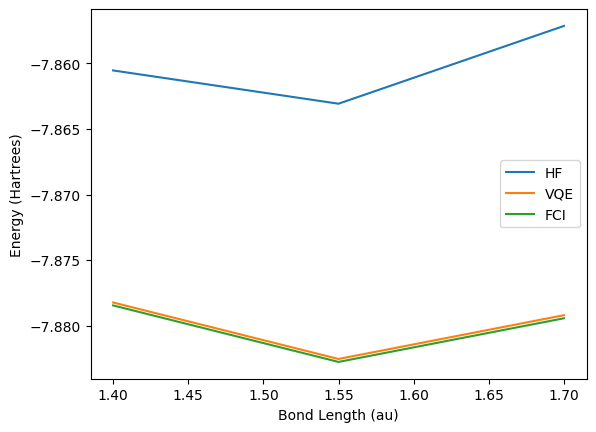

In [ ]:
plt.plot(bond_lengths, h_f_energies, label="HF")
plt.plot(bond_lengths, vqe_energies, label="VQE")
plt.plot(bond_lengths, fci_energies, label="FCI")
plt.xlabel("Bond Length (au)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

## Exercise

Change molecule

## Conclusions

Real world results and experience

## References